In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 5)

#from matplotlib import pyplot as plt
from util import util
import igraph as ig
import numpy as np

# ============================================================
# Repeat relevant operations
# ============================================================

# Build the small graph used to explain concepts
eoh = 4
g = util.build_website_graph(nnodes=4, rate=3, extra_arc_fraction=0.25, seed=42)
flows, paths = util.build_random_paths(g, min_paths=3, max_paths=5,
                                          min_units=1, max_units=10, eoh=eoh, seed=42)
tug = util.build_time_unfolded_graph(g, eoh=eoh)
node_counts, arc_counts = util.get_counts(tug, flows, paths)
node_counts_n, arc_counts_n = util.add_proportional_noise(node_counts, arc_counts, sigma=0.2, seed=42)
mvc, alpha = 0.95, 1
rflows_n, rpaths_n, nneg_duals, mvc_duals = util.solve_path_selection_full(tug, node_counts_n, arc_counts_n,
                                                    alpha=alpha, verbose=0, min_vertex_cover=0.95, return_duals=True, solver='piqp')

/Users/michelelombardi/Library/Caches/pypoetry/virtualenvs/mining-with-co-eC0Z9-8k-py3.11/lib/python3.11/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


# A Model for Our Constrained Subproblem

Let's put to work what we learned

## The Model Variables

**Our pricing problem requires to build paths**

We will model this by introducing _a variable for each time step_:

$$
x_0, x_1, \ldots x_{eoh-1}
$$

**In the domain of each variables, we include:**

* One value for each node in the original graph
  - If $x_t = i$, then we visit node $i$ at time $t$
* One special value to specify that the path has not yet started:
  - If $x_t = -1$, then the path has not yet started at time $t$
* One special value to specify that the path has finished early
  - If $x_t = -2$, then the path is already over at time $t$

**Overall, we have $D_t = \{-2, -1, \ldots, n_v - 1\}$**

## The Model Variables

**We also need to track the path weight**

We will introducing again _a variable for each time step_:

$$
y_0, y_1, \ldots y_{eoh-1}
$$

Where $y_t \in \{-M, \ldots, M\}$, with $M$ being a vary large number

* Using a large number here is not a problems
* ...Since propagation will reduce the domains already at the root node

**The total cost of a path can be obtained by summation**

$$
z = \sum_{t = 0}^{eoh-1} y_i + \alpha
$$

If we want paths with negative weight, we can just add the constraint $z < 0$

## Allowed Transitions

**We now need to model transitions:**

* We can move only along _arcs in the original graph_
  - I.g. we can move from $i$ to $j$ iff $(i, j) \in E$
  - ...Where $E$ refers here to the set of arcs in the original graph
* ...But the _special values_ make for an exception
  - We can always move from $-1$ to $i$
  - We can always move from $i$ to $-2$

**Overall, the allowed transitions are:**

$$
\{(i,j) \ \forall (i,j) \in E\} \cup \{(-1,i) \ \forall i \in V\} \cup \{(i,-2) \ \forall i \in V\}
$$

Where $V$ refers here to the set of nodes in the original graph

## Allowed Transitions

**Let's use our graph as an example**

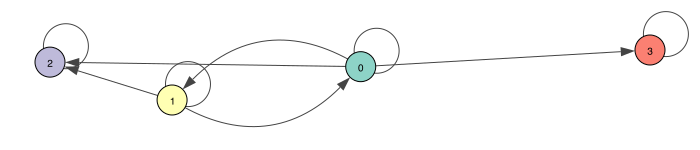

In [2]:
ig.plot(g, **util.get_visual_style(g), bbox=(700, 150), margin=50)

The allowed transitions are:
$$
(0,0), (0,1), (0,2), (0,3), (1,0), (1,1), (2,2), (3,3),\\
(-1,0), (-1,1), (-1,2), (-1,2),\\
(0,-2), (1,-2), (2,-2), (3,-2)
$$

## Transition Weights

**When we move, we accumulate weight**

Let $n(t, i)$ and $e(t, i, j)$ be the TUG indexes for pair $(t,i)$ and triple $(t,i,j)$ 

* When we move _towards_ node $i$ at time $t$, we accumulate $r^v_{n(t,i)} + \lambda_{n(t,i)}$
  - As an exception, moving towards $-2$ accumulates 0 weight
* When we move _from_ node $i$ at _time 0_, we also accumulate $r^v_{n(0,i)} + \lambda_{n(0,i)}$ 
* When we move from $i$ to $j$ at time $t$, we accumulate $r^e_{e(t, i, j)}$

**In detail:**

* If we move from $i$ to $j$ at time $t > 0$, we accumulate:
  - $r^v_{n(t,j)} + \lambda_{n(t,j)}$ for the destination node
  - $r^e_{n(t,i,j)}$ for the arc

## Transition Weights

**When we move, we accumulate weight**

Let $n(t, i)$ and $e(t, i, j)$ be the TUG indexes for pair $(t,i)$ and triple $(t,i,j)$ 

* When we move _towards_ node $i$ at time $t$, we accumulate $r^v_{n(t,i)} + \lambda_{n(t,i)}$
  - As an exception, moving towards $-2$ accumulates 0 weight
* When we move _from_ node $i$ at _time 0_, we also accumulate $r^v_{n(0,i)} + \lambda_{n(0,i)}$ 
* When we move from $i$ to $j$ at time $t$, we accumulate $r^e_{e(t, i, j)}$

**In detail:**

* If we move from $i$ to $j$ at time $t = 0$, we accumulate:
  - $r^v_{n(t,i)} + \lambda_{n(t,i)}$ for the source node
  - $r^v_{n(t,j)} + \lambda_{n(t,j)}$ for the destination node
  - $r^e_{n(t,i,j)}$ for the arc

## Transition Weights

**When we move, we accumulate weight**

Let $n(t, i)$ and $e(t, i, j)$ be the TUG indexes for pair $(t,i)$ and triple $(t,i,j)$ 

* When we move _towards_ node $i$ at time $t$, we accumulate $r^v_{n(t,i)} + \lambda_{n(t,i)}$
  - As an exception, moving towards $-2$ accumulates 0 weight
* When we move _from_ node $i$ at _time 0_, we also accumulate $r^v_{n(0,i)} + \lambda_{n(0,i)}$ 
* When we move from $i$ to $j$ at time $t$, we accumulate $r^e_{e(t, i, j)}$

**Let's see some examples:**

* If we move from $-1$ to $j$ at time $t$, we accumulate:
  - $r^v_{n(t,j)} + \lambda_{n(t,j)}$ for the destination node
* If we move from $i$ to $-2$ at time $t = 0$, we accumulate:
  - $r^v_{n(t,i)} + \lambda_{n(t,i)}$ for the source node
* If we move from $i$ to $-2$ at time $t > 0$, we accumulate 0

## Allowed Transitions

**We can use this information to populate tables**

...And use them within a set of ${\scriptsize \text{ALLOWED}}$ constraints:

$$\begin{align}
& {\scriptsize \text{ALLOWED}}([x_0, x_1, y_0], T_0) & \text{ for time $0$} \\
& {\scriptsize \text{ALLOWED}}([x_1, x_2, y_1], T_1) & \text{ for time $1$} \\
&\ldots & \\
& {\scriptsize \text{ALLOWED}}([x_{eoh-2}, x_{eoh-1}, y_{eoh-1}], T_{eoh-1}) & \text{ for time $eoh-1$}
\end{align}$$

* The constraints allow only feasible transitions
* ...And compute the corresponding cost

**As a result of propagation**

...A restriction on the cost may result in pruned values

* This prevents us from considering many useless paths

## Forbidden Transitions

**We can handle the maximum wait restriction via _forbidden transitions_**

...Using of course the ${\scriptsize \text{FORBIDDEN}}$ constraint

* Let $n_w$ be the maximum number of allowed waits
* ...Then the forbidden transitions are:

$$
\bar{T} = \{\{i\}_{h=0..n_w} \ \forall i \in V \}
$$

I.e. any repetition of a node index for $n_w+1$ times

**Since we have $n_w = 2$ in our case, we forbid:**

$$
\{(0,0,0), (1,1,1), (2,2,2), (3,3,3)\}
$$

I.e. we cannot spend 3 time steps on any node

## Forbidden Transitions

**We need to add $eoh - n_w$ constraints using this table**

...So as to prevent excessive waiting over all the time horizon

$$\begin{align}
& {\scriptsize \text{FORBIDDEN}}([x_0, \ldots, x_{n_w}], \bar{T}) & \text{ for time $n_w$} \\
& {\scriptsize \text{FORBIDDEN}}([x_1, \ldots, x_{n_w+1}], \bar{T}) & \text{ for time $n_w+1$} \\
&\ldots & \\
& {\scriptsize \text{FORBIDDEN}}([x_{eoh-1-n_w}, \ldots, x_{eoh-1}], \bar{T}) & \text{ for time $eoh-1$} 
\end{align}$$

Both in this and in the previous case:

* The number of constraints grows linearly with $eoh$
* The table size is relatively limited

## Model Code

**The code for this model is in the `solve_pricing_problem_maxwaits` function**

We start by building a model using the [Google Or-tools CP-SAT solver](https://developers.google.com/optimization):

```python
mdl = cp_model.CpModel()
```

Then we build the variables:

```python
x = {i: mdl.NewIntVar(-2, mni, f'x_{i}') for i in range(eoh)}
c = {i: mdl.NewIntVar(minwgt, maxwgt, f'c_{i}') for i in range(1, eoh)}
z = mdl.NewIntVar(minwgt * eoh, maxwgt * eoh, 'z')
```

We are using _integer_ variables even if have real weights:

* The trick is to rely on _finite precision_
* Given a weight $w$, we transform it as $round(w * p)$
* So that we obtain an integer, at the expense of some precision

## Model Code

**The code for this model is in the `solve_pricing_problem_maxwaits` function**

We add all ${\scriptsize \text{ALLOWED}}$ constraints

```python
for t in range(1, eoh):
    # Build the table
    ...
    mdl.AddAllowedAssignments([x[t-1], x[t], c[t]], alw)
```

Then the ${\scriptsize \text{FORBIDDEN}}$ constraints

```python
if max_waits is not None:
    for t in range(max_waits, eoh):
        # Build the table
        ...
        mdl.AddForbiddenAssignments(scope, frb)
```

## Model Code

**The code for this model is in the `solve_pricing_problem_maxwaits` function**

Finally, we define the total path weight:

```python
mdl.Add(z == sum(c[i] for i in range(1, eoh)))
```

...And we define a constraint on the $z$ variable:
```python
mdl.Add(z < -round(alpha / prec))
```

* We do not _need_ to minimize $z$ (although we may)
* ...Since it is enough to search for paths with negative weight

## Model Code

**The code for this model is in the `solve_pricing_problem_maxwaits` function**

We build a solver and set a time limit:

```python
slv = cp_model.CpSolver()
slv.parameters.max_time_in_seconds = time_limit
```

We tell the solver not to stop after the first solution:

```python
slv.parameters.enumerate_all_solutions = True
```

We define a callback to store all solutions:

```python
class Collector(cp_model.CpSolverSolutionCallback):
```

...And the we solve the problem:

```python
status = slv.SolveWithSolutionCallback(mdl, collector)
```

## Maximum Wait Pricing in Action

**Let's test our new code in an enumeration task**

In [6]:
ncosts_n, npaths_n = util.solve_pricing_problem_maxwaits(tug, rflows_n, rpaths_n,
                                             node_counts_n, arc_counts_n, max_waits=2,
                                             cover_duals=mvc_duals,
                                             alpha=alpha, filter_paths=False, max_paths=10)
print('COST: PATH')
util.print_solution(tug, ncosts_n, npaths_n, sort='ascending')

COST: PATH
0.20: 0,0 > 1,0 > 2,1 > 3,0
0.20: 2,1 > 3,0
0.20: 2,1 > 3,2
0.20: 0,0 > 1,0 > 2,1 > 3,2
0.28: 1,1 > 2,1 > 3,2
0.28: 1,1 > 2,1 > 3,0
0.34: 0,0 > 1,1 > 2,1 > 3,0
0.34: 0,0 > 1,1 > 2,1 > 3,2
0.48: 1,0 > 2,1 > 3,2
0.76: 0,1 > 1,0 > 2,1 > 3,2
0.76: 0,1 > 1,0 > 2,1 > 3,0


* Paths with more than 2 consecutive visits to the same node are not built

## Maximum Wait Pricing in Action

**Let's test our new code in an enumeration task**

In [7]:
ncosts_n, npaths_n = util.solve_pricing_problem_maxwaits(tug, rflows_n, rpaths_n,
                                             node_counts_n, arc_counts_n, max_waits=2,
                                             cover_duals=mvc_duals,
                                             alpha=alpha, filter_paths=True, max_paths=10)
print('FLOW: PATH')
util.print_solution(tug, ncosts_n, npaths_n, sort='ascending')

FLOW: PATH
-0.00: 1,0 > 2,0 > 3,2
-0.00: 1,0 > 2,0 > 3,3
-0.00: 2,0 > 3,0
-0.00: 2,0 > 3,2
-0.00: 2,3 > 3,3
-0.00: 2,0 > 3,3
-0.00: 0,0 > 1,0 > 2,3 > 3,3


* Some paths (erroneously) have negative waits due to the use of finite precision
* Our column generation code can handle this issue

## Column Generation with Maximum Waits

**Finally, we can test the column generation code itself**

In [19]:
rflows_cg, rpaths_cg = util.trajectory_extraction_cg(tug, node_counts_n, arc_counts_n,
                                    alpha=alpha, min_vertex_cover=mvc, max_iter=30,
                                    verbose=1, max_paths_per_iter=10, max_waits=2, solver='piqp')
print('FLOW: PATH')
util.print_solution(tug, rflows_cg, rpaths_cg, sort='descending', max_paths=6)
sse = util.get_reconstruction_error(tug, rflows_cg, rpaths_cg, node_counts_n, arc_counts_n)
print(f'RSSE: {np.sqrt(sse):.2f}')

It.0, sse: 209.13, #paths: 27, new: 11
It.1, sse: 202.55, #paths: 38, new: 11
It.2, sse: 141.07, #paths: 45, new: 7
It.3, sse: 131.99, #paths: 51, new: 6
It.4, sse: 103.51, #paths: 59, new: 8
It.5, sse: 83.07, #paths: 59, new: 0
FLOW: PATH
8.29: 3,3
5.76: 0,2
5.39: 2,3
4.56: 3,2
3.29: 0,1 > 1,1 > 2,0 > 3,0
3.05: 1,2
...
RSSE: 9.11
